In [11]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import torch.optim as optim
import math

from src.training.train import (
    FocalLoss
) 
from src.data.datasets import CloudHoleDataset
from src.models.models import CNN_Model

from sklearn.model_selection import TimeSeriesSplit
import torch
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
cmap = plt.get_cmap('Greys_r')

labels_path = '../data/processed/julia_labels.csv'
nc_path = '../data/raw/seviri/'


In [12]:
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 0.001
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [27]:
def year_stats(labels_csv):
    df = pd.read_csv(labels_csv, index_col=0, parse_dates=True)
    df = df.dropna(subset=["label"])
    df["y"] = (df["label"] == "cloud_hole").astype(int)
    return df.groupby(df.index.year)["y"].agg(["count", "sum", "mean"])

stats = year_stats(labels_path)
print(stats)


        count  sum      mean
2005.0     66   51  0.772727
2006.0     66    0  0.000000
2007.0     33   14  0.424242
2010.0    132    0  0.000000
2013.0     99   18  0.181818
2015.0    132   29  0.219697
2016.0     99   61  0.616162
2017.0     66    0  0.000000
2019.0    132   33  0.250000


In [30]:
# 2010, 2017
TRAIN_YEARS = [2005, 2007, 2013, 2016, ]
TEST_YEARS = [2015, 2019]


dataset = CloudHoleDataset(
    labels = labels_path,
    data_dir = nc_path, 
    train = True, 
    augment=False,
    years = TRAIN_YEARS
)


test_dataset = CloudHoleDataset(
    labels = labels_path,
    data_dir = nc_path, 
    train = False, 
    years = TEST_YEARS, 
    mean = dataset.mean, 
    std = dataset.std, 
    min = dataset.min, 
    max = dataset.max
)

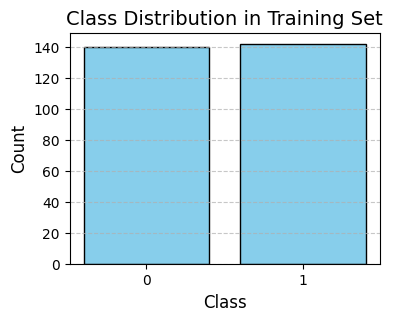

dataset Distribution: Counter({1: 142, 0: 140})


In [31]:
from collections import Counter

def plot_class_distribution(labels, dataset_name="Dataset"):
    """
    Plots the class distribution of the labels.
    :param labels: List or array-like containing class labels.
    :param dataset_name: Name of the dataset (e.g., "Training" or "Validation").
    """
    label_counts = Counter(labels)
    classes = list(label_counts.keys())
    counts = list(label_counts.values())
    
    # Plot
    plt.figure(figsize=(4, 3))
    plt.bar(classes, counts, color='skyblue', edgecolor='black')
    plt.title(f"Class Distribution in {dataset_name}", fontsize=14)
    plt.xlabel("Class", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(classes, fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

_train_dataloader_one_batch = DataLoader(dataset, batch_size=1, shuffle=False)
all_train_labels = []

for _, label_tensor in _train_dataloader_one_batch:
    all_train_labels.append(label_tensor.item())

plot_class_distribution(all_train_labels, dataset_name="Training Set")

print("dataset Distribution:", Counter(all_train_labels))


- timeseries split
- criterion
- optimizer


In [33]:
from collections import Counter
n_splits = 4
  
tscv = TimeSeriesSplit(n_splits = n_splits)

def print_class_stats(name, indices):
    labels = [dataset[i][1] for i in indices]
    counts = Counter(labels)
    total = len(labels)
    print(f"{name}: {counts} | ratio(class1) = {counts[1]/total:.3f}")

for fold, (train_idx, val_idx) in enumerate(tscv.split(range(len(dataset)))):
    print(f"Fold {fold + 1}/{n_splits}")
    labels_train = [dataset[i][1] for i in train_idx]
    labels_val = [dataset[i][1] for i in val_idx]

    print("Train ratio:", np.mean(labels_train))
    print("Val ratio:", np.mean(labels_val))
    print("-----")

Fold 1/4
Train ratio: 0.8793103448275862
Val ratio: 0.25
-----
Fold 2/4
Train ratio: 0.5701754385964912
Val ratio: 0.19642857142857142
-----
Fold 3/4
Train ratio: 0.4470588235294118
Val ratio: 0.48214285714285715
-----
Fold 4/4
Train ratio: 0.4557522123893805
Val ratio: 0.6964285714285714
-----


In [ ]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(loader), 100 * correct / total

def validate(model, loader, criterion, device, threshold=0.5):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            probs = torch.softmax(outputs, dim=1)[:, 1]
            preds = (probs > threshold).long()

            total_loss += loss.item()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(loader), 100 * correct / total


In [36]:
n_splits = 4
patience = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
fold_metrics = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(range(len(dataset)))):
    print(f"\nFold {fold+1}/{n_splits}")

    # ---- class distribution check ----
    y_train = [dataset[i][1] for i in train_idx]
    y_val = [dataset[i][1] for i in val_idx]
    print(f"Train ratio: {np.mean(y_train):.3f}")
    print(f"Val ratio:   {np.mean(y_val):.3f}")

    # ---- data loaders ----
    train_loader = DataLoader(
        Subset(dataset, train_idx),
        batch_size=BATCH_SIZE,
        shuffle=False
    )
    val_loader = DataLoader(
        Subset(dataset, val_idx),
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    # ---- model & optimizer ----
    model = CNN_Model(number_of_classes=2).to(DEVICE)
    weights = torch.tensor([0.6, 0.4]).to(DEVICE)
    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    best_val_loss = float("inf")
    counter = 0

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    # ---- epochs ----
    for epoch in range(EPOCHS):
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, DEVICE
        )
        val_loss, val_acc = validate(
            model, val_loader, criterion, DEVICE, threshold=0.5
        )

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(
            f"Epoch {epoch+1:02d} | "
            f"Train loss: {train_loss:.4f}, acc: {train_acc:.2f}% | "
            f"Val loss: {val_loss:.4f}, acc: {val_acc:.2f}%"
        )

        # ---- early stopping ----
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), f"best_model_fold_{fold+1}.pth")
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping")
                break

    fold_metrics.append((best_val_loss, val_acc))



Fold 1/4
Train ratio: 0.879
Val ratio:   0.250
Epoch 01 | Train loss: 0.6554, acc: 87.93% | Val loss: 281.1761, acc: 25.00%
Epoch 02 | Train loss: 69.5542, acc: 87.93% | Val loss: 166.1400, acc: 25.00%
Epoch 03 | Train loss: 41.0239, acc: 87.93% | Val loss: 49.5922, acc: 25.00%
Epoch 04 | Train loss: 12.2188, acc: 87.93% | Val loss: 1.7539, acc: 75.00%
Epoch 05 | Train loss: 17.7718, acc: 12.07% | Val loss: 0.4317, acc: 75.00%
Epoch 06 | Train loss: 5.4024, acc: 12.07% | Val loss: 19.0205, acc: 25.00%
Epoch 07 | Train loss: 4.6479, acc: 87.93% | Val loss: 30.0718, acc: 25.00%
Epoch 08 | Train loss: 7.3617, acc: 87.93% | Val loss: 34.5117, acc: 25.00%
Epoch 09 | Train loss: 8.4366, acc: 87.93% | Val loss: 33.8041, acc: 25.00%
Epoch 10 | Train loss: 8.2459, acc: 87.93% | Val loss: 29.9426, acc: 25.00%
Early stopping

Fold 2/4
Train ratio: 0.570
Val ratio:   0.196
Epoch 01 | Train loss: 89.8726, acc: 50.00% | Val loss: 35.5278, acc: 19.64%
Epoch 02 | Train loss: 9.4275, acc: 76.32% | Val

In [18]:
n_splits = 3  
tscv = TimeSeriesSplit(n_splits = n_splits)
fold_metrics = []



patience = 5  # Number of epochs to wait before stopping if no improvement


for fold, (train_idx, val_idx) in enumerate(tscv.split(range(len(dataset)))):
    labels_train = [dataset[i][1] for i in train_idx]
    labels_val = [dataset[i][1] for i in val_idx]

    print("Train ratio:", np.mean(labels_train))
    print("Val ratio:", np.mean(labels_val))
    train_losses = []
    val_losses = []
    val_accuracies = []
    train_accuracies = []
    
    print(f"Fold {fold + 1}/{n_splits}")
    
    print("\tTRAIN indices:", train_idx)
    print("\tVALIDATION indices:", val_idx)

    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = CNN_Model(2) 
    model.to(DEVICE)  
    
    weights = torch.tensor([0.6, 0.4]).to(DEVICE)
    criterion = nn.CrossEntropyLoss(weight=weights)
    # criterion = FocalLoss(num_classes=2)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    counter = 0
    best_val_loss = float('inf') 
    
    for epoch in range(EPOCHS):
        # Training
        train_loss_epoch = 0

        train_loss = 0
        correct = 0
        total = 0
        
        model.train()
        for images, labels in train_loader:
            
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            train_loss_epoch += loss.item()

        train_losses.append(train_loss_epoch / len(train_loader))
        
        train_accuracies.append(100 * correct / total)
        
        # Validation
        model.eval()
        val_loss_epoch = 0

        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():

            for images, labels in val_loader:
                images = images.to(DEVICE)
                labels = labels.to(DEVICE)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                
                # _, predicted = torch.max(outputs, 1)
                probs = torch.softmax(outputs, dim=1)[:, 1]  # P(class=1)

                predicted = probs > 0.5

                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                val_loss_epoch += criterion(outputs, labels).item()
                
        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total

        val_losses.append(val_loss_epoch / len(val_loader))
        val_accuracies.append(100 * correct / total)
        
        print(f"Epoch {epoch + 1}, Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

        # Early Stopping Logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0  # Reset patience counter

            torch.save({
                'fold': fold + 1,
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_accuracy': val_accuracy
            }, f'custom_cnn_best_model_fold_{fold + 1}.pth')

        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break  # Stop training if patience is exceeded


    plt.figure(figsize=(12, 5))   
    
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, 'r-', label='Training Accuracy')
    plt.plot(val_accuracies, 'b-', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Fold {fold + 1} - Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, 'r-', label='Training Loss')
    plt.plot(val_losses, 'b-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Fold {fold + 1} - Training vs Validation Loss')
    plt.legend()
    plt.grid(True) 
    
    plt.tight_layout()
    plt.savefig(f'training_curves_fold_{fold + 1}.png')
    plt.close()

    fold_metrics.append((val_loss, val_accuracy))

avg_val_loss = np.mean([metrics[0] for metrics in fold_metrics])
avg_val_accuracy = np.mean([metrics[1] for metrics in fold_metrics])

print(f"Average Validation Loss: {avg_val_loss:.4f}")
print(f"Average Validation Accuracy: {avg_val_accuracy:.2f}%")


Train ratio: 0.7183098591549296
Val ratio: 0.208955223880597
Fold 1/5
	TRAIN indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70]
	VALIDATION indices: [ 71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137]
Epoch 1, Validation Loss: 46.5367, Accuracy: 20.90%
Epoch 2, Validation Loss: 3.1941, Accuracy: 79.10%
Epoch 3, Validation Loss: 2.4293, Accuracy: 79.10%
Epoch 4, Validation Loss: 1.1953, Accuracy: 79.10%
Epoch 5, Validation Loss: 1.9277, Accuracy: 20.90%
Epoch 6, Validation Loss: 5.6045, Accuracy: 20.90%
Epoch 7, Validation Loss: 0.2285, Accuracy: 79.10%
Epoch 8, Validation Loss: 0.3764, Accuracy: 7

Evaluating Test Set with Best Model of Fold 1
Fold 1 - Test Loss: 0.7606, Test Accuracy: 77.69%
Evaluating Test Set with Best Model of Fold 2
Fold 2 - Test Loss: 6.4033, Test Accuracy: 77.69%
Evaluating Test Set with Best Model of Fold 3
Fold 3 - Test Loss: 10.3691, Test Accuracy: 77.69%
Evaluating Test Set with Best Model of Fold 4
Fold 4 - Test Loss: 0.4661, Test Accuracy: 72.73%

Overall Test Loss (Average across folds): 4.4998
Overall Test Accuracy (Average across folds): 76.45%

Overall Classification Report:
                precision    recall  f1-score   support

Non Cloud Hole       0.78      0.97      0.86       376
    Cloud Hole       0.33      0.06      0.10       108

      accuracy                           0.76       484
     macro avg       0.56      0.51      0.48       484
  weighted avg       0.68      0.76      0.69       484



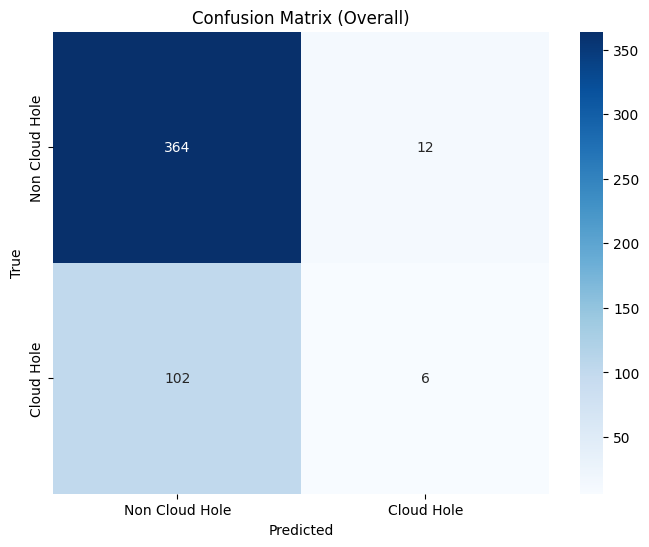

Final model trained and saved as final_model.pth


In [37]:


test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

fold_test_metrics = []  # To store metrics for each fold
all_test_labels = []
all_test_predictions = []

# Loop through all folds
for fold in range(n_splits):
    print(f"Evaluating Test Set with Best Model of Fold {fold + 1}")
    
    # Load the best model for this fold
    checkpoint = torch.load(f"custom_cnn_best_model_fold_{fold + 1}.pth")
    model = CNN_Model(number_of_classes=2)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    model.to(DEVICE)

    # Initialize variables for fold-specific metrics
    test_loss = 0
    correct = 0
    total = 0
    fold_labels = []
    fold_predictions = []

    # Evaluate the model
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(images)
            test_loss += criterion(outputs, labels).item()

            # Get predicted classes
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Store fold predictions and labels
            fold_labels.extend(labels.cpu().numpy())
            fold_predictions.extend(predicted.cpu().numpy())

    # Compute fold-specific metrics
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / total
    print(f"Fold {fold + 1} - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
    # Save metrics for this fold
    fold_test_metrics.append((test_loss, test_accuracy))
    all_test_labels.extend(fold_labels)
    all_test_predictions.extend(fold_predictions)

# Compute overall metrics
avg_test_loss = np.mean([metrics[0] for metrics in fold_test_metrics])
avg_test_accuracy = np.mean([metrics[1] for metrics in fold_test_metrics])

print(f"\nOverall Test Loss (Average across folds): {avg_test_loss:.4f}")
print(f"Overall Test Accuracy (Average across folds): {avg_test_accuracy:.2f}%")

# Classification Report and Confusion Matrix
print("\nOverall Classification Report:")
print(classification_report(all_test_labels, all_test_predictions, target_names=["Non Cloud Hole", "Cloud Hole"]))

conf_matrix = confusion_matrix(all_test_labels, all_test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non Cloud Hole", "Cloud Hole"], yticklabels=["Non Cloud Hole", "Cloud Hole"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Overall)")
plt.show()


torch.save(model.state_dict(), "custom_cnn_final_model.pth")
print("Final model trained and saved as final_model.pth")


Final Model Test Loss: 0.0259
Final Model Test Accuracy: 85.16%

Final Model Classification Report:
                precision    recall  f1-score   support

Non Cloud Hole       0.85      1.00      0.92       155
    Cloud Hole       0.00      0.00      0.00        27

      accuracy                           0.85       182
     macro avg       0.43      0.50      0.46       182
  weighted avg       0.73      0.85      0.78       182



/home/plato/.virtualenvs/dlcloudhole/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/plato/.virtualenvs/dlcloudhole/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/plato/.virtualenvs/dlcloudhole/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

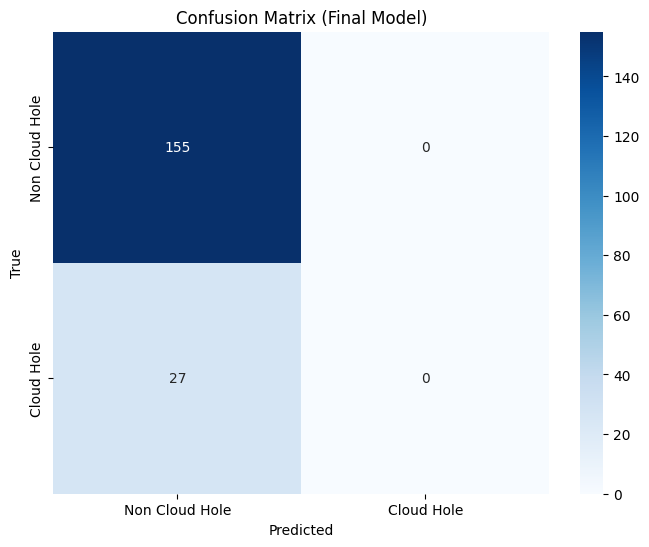

In [19]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

model.load_state_dict(torch.load("custom_cnn_final_model.pth"))
model.to(DEVICE)
model.eval()

# Initialize test metrics
test_loss = 0
correct = 0
total = 0
all_test_labels = []
all_test_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        outputs = model(images)
        test_loss += criterion(outputs, labels).item()

        _, predicted = torch.max(outputs, 1)

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        all_test_labels.extend(labels.cpu().numpy())
        all_test_predictions.extend(predicted.cpu().numpy())

# Compute final test accuracy
final_test_loss = test_loss / len(test_loader)
final_test_accuracy = 100 * correct / total

print(f"\nFinal Model Test Loss: {final_test_loss:.4f}")
print(f"Final Model Test Accuracy: {final_test_accuracy:.2f}%")

# Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("\nFinal Model Classification Report:")
print(classification_report(all_test_labels, all_test_predictions, target_names=["Non Cloud Hole", "Cloud Hole"]))

# Confusion Matrix
conf_matrix = confusion_matrix(all_test_labels, all_test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non Cloud Hole", "Cloud Hole"], yticklabels=["Non Cloud Hole", "Cloud Hole"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Final Model)")
plt.show()